In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mandelbrot.mandelbrot_functions import mandelbrot_dataset_creator, plot_mandelbrot_dataset

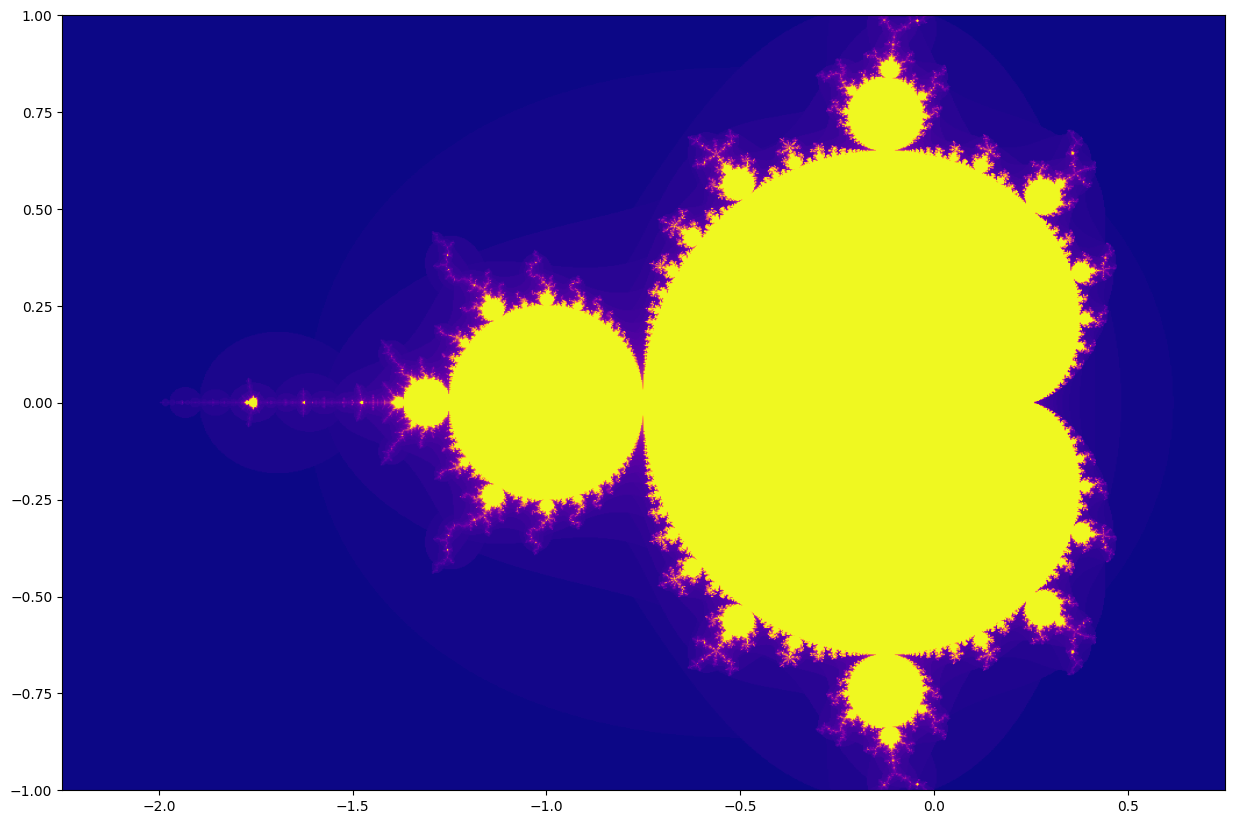

In [31]:
#test out full functionality (default values)
dataset = mandelbrot_dataset_creator(classification_threshold=1)
plot_mandelbrot_dataset(dataset)

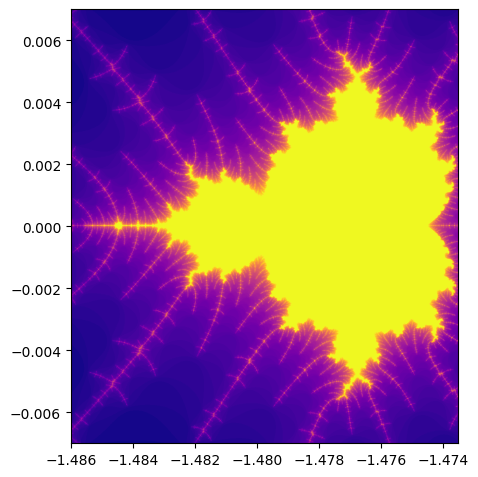

In [32]:
#test out full adjustable functionality (keyword args)
dataset = mandelbrot_dataset_creator(real_start = -1.486, 
                                     real_end = -1.4735, 
                                     real_nr_pixels = 1000, 
                                     imag_start = -0.007j, 
                                     imag_end = 0.007j, 
                                     imag_nr_pixels = 2000,
                                     initial_z = 0, 
                                     exponent = 2,
                                     nr_iterations = 100,
                                     classification_threshold = 2)

plot_mandelbrot_dataset(dataset, fig_size = (5,10), show_color_bar = False)

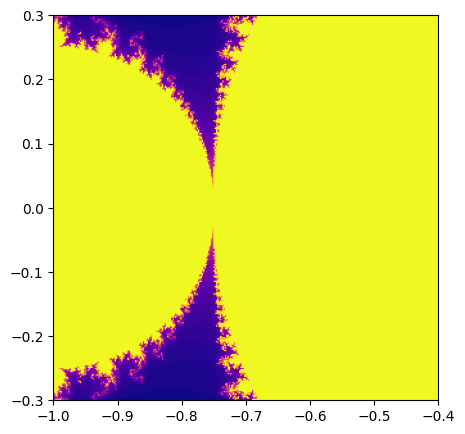

In [33]:
#test out full adjustable functionality (keyword args)
dataset = mandelbrot_dataset_creator(real_start = -1, 
                                  real_end = -0.4, 
                                  real_nr_pixels = 300, 
                                  imag_start = -0.3j, 
                                  imag_end = 0.3j, 
                                  imag_nr_pixels = 300,
                                  initial_z = 0, 
                                  exponent = 2,
                                  nr_iterations = 100)

plot_mandelbrot_dataset(dataset, fig_size = (5,5))

In [38]:
"""Calculate raw data points"""

#Get raw data points 
df = mandelbrot_dataset_creator(real_start = -1, 
                                  real_end = -0.4, 
                                  real_nr_pixels = 200, 
                                  imag_start = -0.3j, 
                                  imag_end = 0.3j, 
                                  imag_nr_pixels = 200,
                                  initial_z = 0, 
                                  exponent = 2,
                                  nr_iterations = 100)

#get dimension for later usage
c_real = np.float64(df.columns)
c_imag = df.index

#transpose/ transform data from shape (1000, 1000) -> (1000000, 3)
data = pd.melt(df.reset_index(), id_vars= "index", value_vars=df.columns[1:]).astype({"variable": float})

In [39]:
#rename columns and inspect data
data.columns = ["imag_part", "real_part", "diverges_at_iter"]

print(f"Data is {round(data.memory_usage(deep=True).sum() / (1024 ** 2))} Megabytes big")
data.head(20)

Data is 1 Megabytes big


,imag_part,real_part,diverges_at_iter
0,-0.300000,-0.996985,45
1,-0.296985,-0.996985,35
2,-0.293970,-0.996985,61
3,-0.290955,-0.996985,57
4,-0.287940,-0.996985,99
5,-0.284925,-0.996985,99
6,-0.281910,-0.996985,99
7,-0.278894,-0.996985,99
8,-0.275879,-0.996985,99
9,-0.272864,-0.996985,99


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

"""Prepare raw data for DL Model"""

#create features, targets
X = data[["real_part", "imag_part"]]
y = data[["diverges_at_iter"]]

#create preprocessor pipe
#X_preprocessor_pipe = make_pipeline(MinMaxScaler(), PolynomialFeatures(degree=2), MinMaxScaler())
y_preprocessor_pipe = make_pipeline(MinMaxScaler())
X_preprocessor_pipe = make_pipeline(MinMaxScaler())

#standardscale all data 
X_trans = X_preprocessor_pipe.fit_transform(X)
y_trans = y_preprocessor_pipe.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29850, 2) (9950, 2) (29850, 1) (9950, 1)


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.config import set_visible_devices

#decide wheather to use GPU or not
use_gpu = True
if not use_gpu:
    set_visible_devices([], 'GPU')

def initialize_model():                                                                

    """Create model architecture"""

    model = Sequential()

    model.add(Dense(32, activation=LeakyReLU(), input_shape = (X_trans.shape[1],)))
    model.add(Dense(32, activation=LeakyReLU(alpha=0.01)))
    model.add(Dense(32, activation=LeakyReLU(alpha=0.01)))
    model.add(Dense(32, activation=LeakyReLU(alpha=0.01)))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
            loss = "mse", 
            optimizer = Adam(learning_rate=0.001), 
            metrics = ["mae"]
        )

    return model

In [44]:
"""Initialise and inspect model"""

model = initialize_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                96        
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3297 (12.88 KB)
Trainable params: 3297 (12.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau

"""train neural network"""

#create custom callback storing model at each epoch
class ModelCheckpointList(Callback):
    def __init__(self):
        super(ModelCheckpointList, self).__init__()
        self.models = []

    def on_epoch_end(self, epoch, logs=None):
        # Save the model's architecture and weights
        config = self.model.get_config()
        weights = self.model.get_weights()

        # Recreate a new model from the architecture and weights
        new_model = Sequential.from_config(config)
        new_model.set_weights(weights)

        # Append the model to the list
        self.models.append(new_model)

#init model
model = initialize_model()

#define callbacks
early_stopping = EarlyStopping(patience = 20, monitor = "val_loss", restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience = 10, min_lr=0.00001)
checkpoint_list_callback = ModelCheckpointList()

#train model (always with ca. batch_size = 1000)
history = model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    batch_size = 32,
    epochs = 100,
    callbacks = [early_stopping, reduce_lr, checkpoint_list_callback])

Epoch 1/100
747/747 [==============================] - 1s 599us/step - loss: 0.0603 - mae: 0.1573 - val_loss: 0.0171 - val_mae: 0.0611 - lr: 0.0010
Epoch 2/100
747/747 [==============================] - 0s 570us/step - loss: 0.0154 - mae: 0.0505 - val_loss: 0.0145 - val_mae: 0.0450 - lr: 0.0010
Epoch 3/100
747/747 [==============================] - 0s 599us/step - loss: 0.0127 - mae: 0.0398 - val_loss: 0.0136 - val_mae: 0.0404 - lr: 0.0010
Epoch 4/100
747/747 [==============================] - 0s 554us/step - loss: 0.0113 - mae: 0.0361 - val_loss: 0.0114 - val_mae: 0.0363 - lr: 0.0010
Epoch 5/100
747/747 [==============================] - 0s 560us/step - loss: 0.0111 - mae: 0.0349 - val_loss: 0.0113 - val_mae: 0.0358 - lr: 0.0010
Epoch 6/100
747/747 [==============================] - 0s 587us/step - loss: 0.0111 - mae: 0.0348 - val_loss: 0.0103 - val_mae: 0.0350 - lr: 0.0010
Epoch 7/100
747/747 [==============================] - 0s 573us/step - loss: 0.0110 - mae: 0.0341 - val_loss: 0.

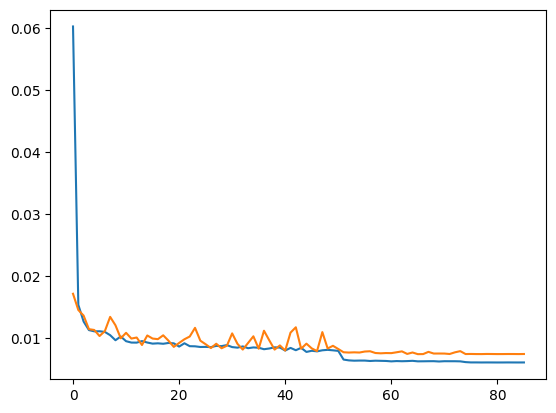

In [50]:
#plot loss and val los
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [51]:
#get predicitons for each pixel in original grid from final model
predictions = model.predict(X_trans, batch_size=int(len(X_train) / 100))
predictions



134/134 [==============================] - 0s 340us/step


array([[0.41304275],
       [0.5111655 ],
       [0.6102637 ],
       ...,
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)

In [52]:
#inverse transform predicitions
predictions = y_preprocessor_pipe.inverse_transform(predictions)
predictions

array([[43.82602 ],
       [53.049557],
       [62.364788],
       ...,
       [99.00001 ],
       [99.00001 ],
       [99.00001 ]], dtype=float32)

In [53]:
#load predictions into df and convert to grid 
prediciton_df = pd.DataFrame({"real_part" : X["real_part"], "imag_part" : X["imag_part"], "prediction" : predictions[:,0]})
prediciton_df = prediciton_df.pivot(index = "imag_part", columns = "real_part", values = "prediction")
prediciton_df.head(10)

real_part,-0.996985,-0.993970,-0.990955,-0.987940,-0.984925,-0.981910,-0.978894,-0.975879,-0.972864,-0.969849,...,-0.427136,-0.424121,-0.421106,-0.418090,-0.415075,-0.412060,-0.409045,-0.406030,-0.403015,-0.400000
imag_part,,,,,,,,,,,,,,,,,,,,,
-0.300000,43.826019,32.848354,26.742891,22.157749,18.917185,16.821770,15.016501,13.474568,13.358086,13.312179,...,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008
-0.296985,53.049557,39.448235,30.461029,25.125990,20.918179,18.241697,16.240946,14.514434,14.152473,13.968956,...,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008
-0.293970,62.364788,48.329979,35.658604,28.636972,23.598364,19.801455,17.593845,15.685315,15.078259,14.890609,...,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008
-0.290955,70.567291,57.781212,43.796021,33.021622,26.921936,22.262468,19.090599,16.979855,16.092289,15.895869,...,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008
-0.287940,77.967598,66.739868,53.083183,39.419472,30.637478,25.295446,21.016897,18.407764,17.201965,16.988726,...,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008
-0.284925,85.563034,74.354973,62.396820,48.363434,35.841190,28.826447,23.758221,19.926632,18.404697,18.173830,...,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008
-0.281910,89.922630,82.271706,70.629341,57.814308,43.766010,33.195461,27.037085,22.181599,19.728752,19.500957,...,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008
-0.278894,92.937431,88.634277,78.178009,66.806175,53.116795,39.252537,30.526117,24.989136,21.558876,21.131647,...,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008
-0.275879,95.021164,92.435410,85.947998,74.352692,62.013248,47.471664,35.126503,28.189632,24.120296,23.607359,...,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008,99.000008


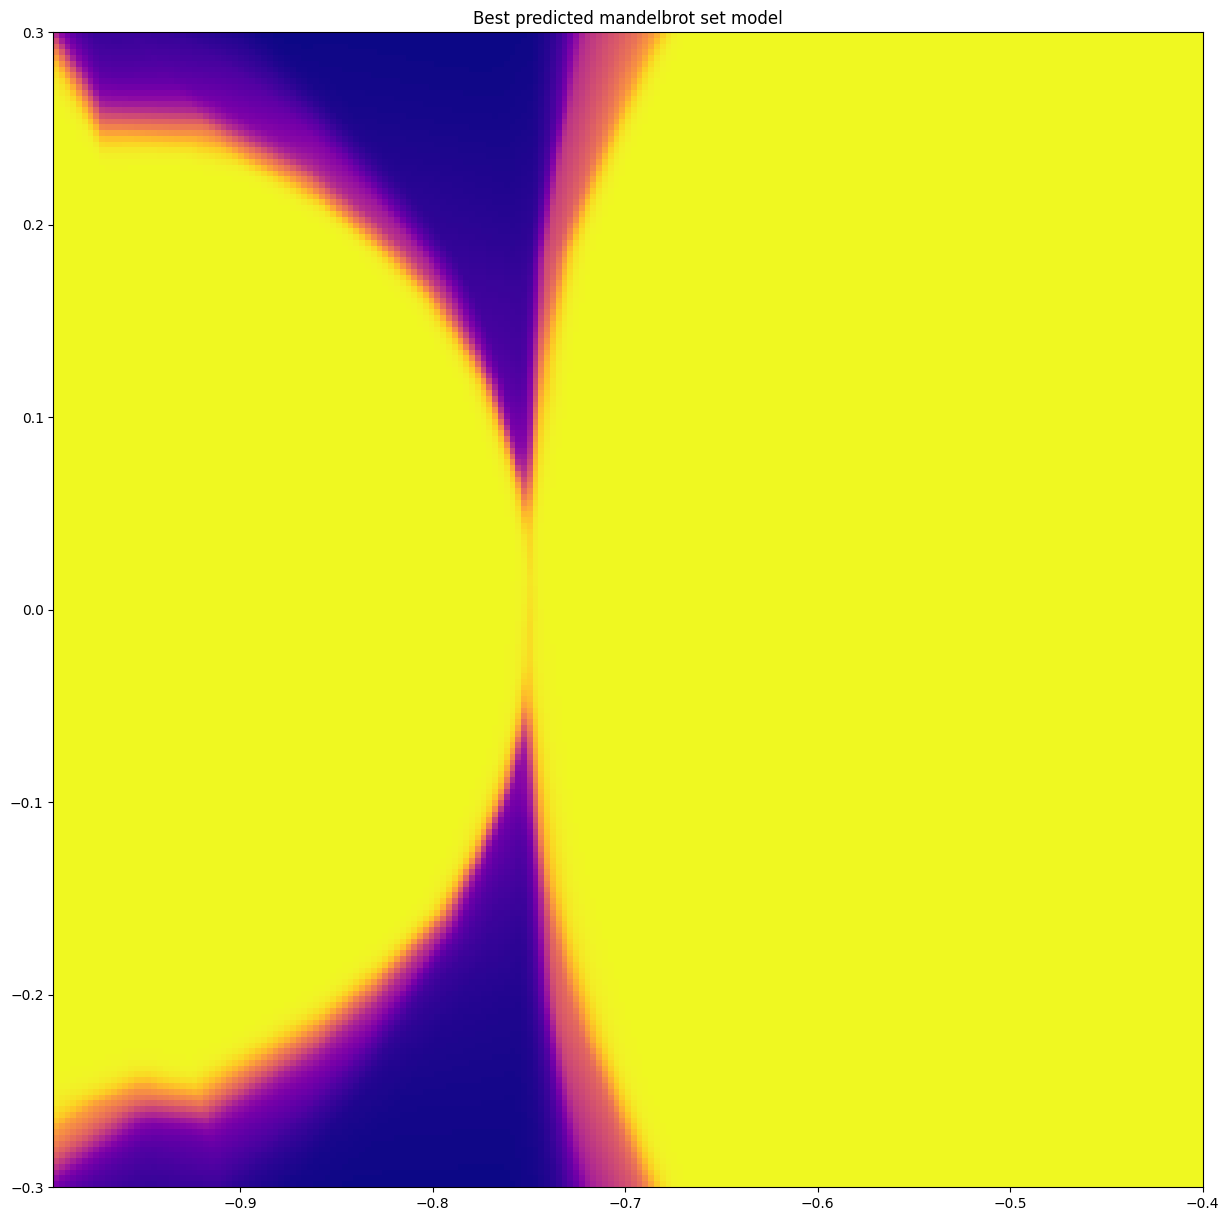

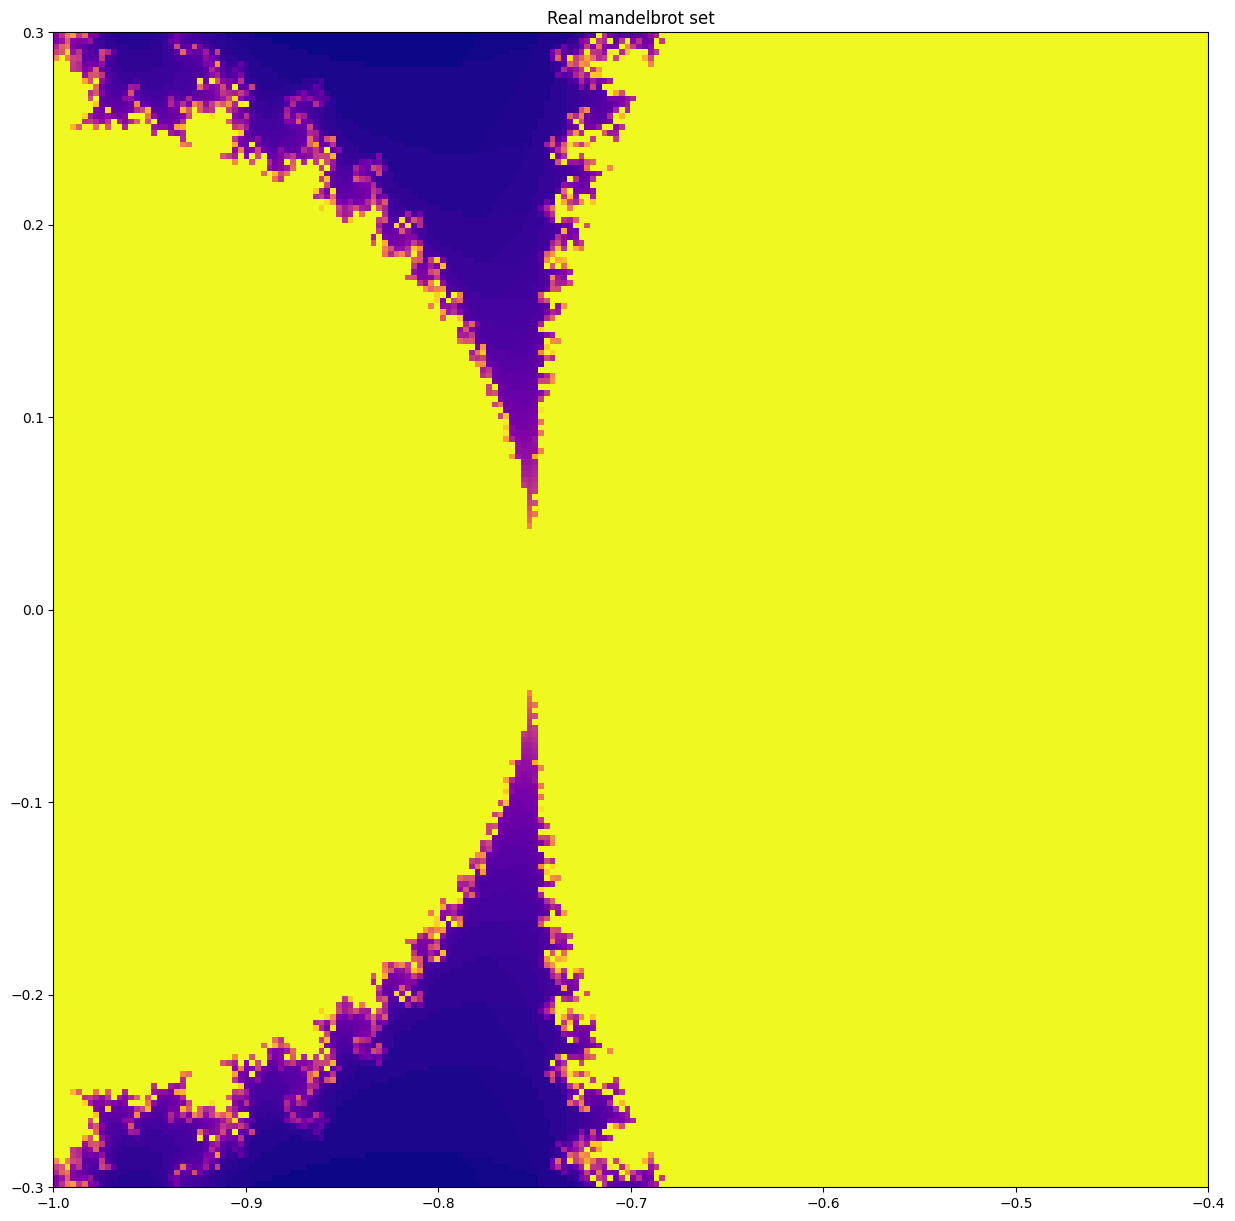

In [54]:
#plot predictions vs real values
plot_mandelbrot_dataset(prediciton_df, fig_size = (15,15), title = "Best predicted mandelbrot set model")
plot_mandelbrot_dataset(df, fig_size = (15,15), title = "Real mandelbrot set")


In [55]:
X_trans

array([[0.        , 0.        ],
       [0.        , 0.00502513],
       [0.        , 0.01005025],
       ...,
       [1.        , 0.98994975],
       [1.        , 0.99497487],
       [1.        , 1.        ]])

In [56]:
import ipywidgets as widgets

"""create predictions for each of the saved (via custom callback) models after each epoch"""

#step size between epochs
step_size = 1

#init results df, that will contain predictions per model
prediction_dfs = []

#iterate over each model in each epoch
for epoch in range(0, len(checkpoint_list_callback.models), step_size):

    #get model at epoch 
    model = checkpoint_list_callback.models[epoch]
    
    #calc predicitons
    predictions = model.predict(X_trans, verbose=1, batch_size = int(len(X_train) / 1000))

    #detransform predicitions
    predictions = y_preprocessor_pipe.inverse_transform(predictions)

    #load predictions into df and convert to grid 
    prediction_df = pd.DataFrame({"real_part" : X["real_part"], "imag_part" : X["imag_part"], "prediction" : predictions[:,0]})
    prediction_df = prediction_df.pivot(index = "imag_part", columns = "real_part", values = "prediction")
    prediction_df.head(10)

    #save result
    prediction_dfs.append(prediction_df)

1373/1373 [==============================] - 1s 344us/step


In [49]:
import ipywidgets as widgets

"""create predictions for each of the saved (via custom callback) models after each epoch"""

"""2nd Version, where, only every 10th pixel is shown """

#step size between epochs
step_size = 1

#percentage of pixels to show -> IMPORTANT: I think only works, when it is divisor of both pixel numbers in model training
factor_pixel = 10

#init results df, that will contain predictions per model
prediction_dfs = []

#iterate over each model in each epoch
for epoch in range(0, len(checkpoint_list_callback.models), step_size):

    #get model at epoch 
    model = checkpoint_list_callback.models[epoch]
    
    #calc predicitons
    predictions = model.predict(X_trans[::factor_pixel], verbose=1, batch_size = int(len(X_train) / 1000))

    #detransform predicitions
    predictions = y_preprocessor_pipe.inverse_transform(predictions)

    #load predictions into df and convert to grid 
    prediction_df = pd.DataFrame({"real_part" : X["real_part"].iloc[::factor_pixel], "imag_part" : X["imag_part"].iloc[::factor_pixel], "prediction" : predictions[:,0]})
    prediction_df = prediction_df.pivot(index = "imag_part", columns = "real_part", values = "prediction")
    prediction_df.head(10)

    #save result

    prediction_dfs.append(prediction_df)

134/134 [==============================] - 0s 1ms/step


2023-08-22 22:24:10.448283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-22 22:24:10.452129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-08-22 22:24:10.454354: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


134/134 [==============================] - 0s 1ms/step


2023-08-22 22:24:10.694177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-22 22:24:10.697816: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-08-22 22:24:10.700196: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


104/134 [======================>.......] - ETA: 0s

2023-08-22 22:24:10.917642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-22 22:24:10.921184: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-08-22 22:24:10.923206: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


134/134 [==============================] - 0s 1ms/step


2023-08-22 22:24:11.206640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-22 22:24:11.210044: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-08-22 22:24:11.212031: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


134/134 [==============================] - 0s 1ms/step


2023-08-22 22:24:11.455155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-22 22:24:11.458501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-08-22 22:24:11.460490: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


134/134 [==============================] - 0s 1ms/step


2023-08-22 22:24:11.685415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-22 22:24:11.688984: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-08-22 22:24:11.691069: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


134/134 [==============================] - 0s 1ms/step


2023-08-22 22:24:11.920587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-22 22:24:11.924019: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-08-22 22:24:11.926080: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


134/134 [==============================] - 0s 1ms/step


2023-08-22 22:24:12.179947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-22 22:24:12.183943: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-08-22 22:24:12.186222: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


134/134 [==============================] - 0s 1ms/step


2023-08-22 22:24:12.424424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-22 22:24:12.427925: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-08-22 22:24:12.430037: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


134/134 [==============================] - 0s 1ms/step


2023-08-22 22:24:12.668512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-22 22:24:12.672125: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-08-22 22:24:12.674116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


In [ ]:
from IPython.display import clear_output

clear_output(wait=True)

#Function to display the image given an index
def plot_image(i=0):
    plot_mandelbrot(prediction_dfs[i])
    
#Create an interactive slider
widgets.interactive(plot_image, i=(0, len(prediction_dfs) - 1))

interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…